## Extract MINST data

In [8]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
from numpy import linalg as LA
import copy
import itertools

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Functions for amplitude encoding

In [9]:
def gen_angles(x):
    """function that generates angles for amplitude encoding"""
    
    if len(x)>1:
        new_x = np.zeros(int(len(x)/2))
        
        for k in range(len(new_x)):
            new_x[k] = np.sqrt(x[2*k]**2 + x[2*k+1]**2)
        
        inner_angles = gen_angles(new_x)
                
        angles = np.zeros(int(len(x)/2))

        for k in range(len(new_x)):
            if(new_x[k]!=0):
                if(x[2*k]>0):
                    angles[k] = 2*np.arcsin(x[2*k+1]/new_x[k])
                else:
                    angles[k] = 2*np.pi - 2*np.arcsin(x[2*k+1]/new_x[k])
            else:
                angles[k] = 0
        
        angles = np.concatenate((inner_angles, angles))
        
        return np.array(angles)
    
    else: return np.ones(0)
    
    
    
n_0 = 20  # Number of elements in the array
array = [0] * n_0  # Initialize the array with zeros

# Calculate the cumulative sums of powers of 2
for i in range(n_0):
    if i == 0:
        array[i] = 1
    else:
        array[i] = array[i-1] + 2 ** i
array = np.array(array)-1



def level(k):
    
    for i in range(len(array)):
        
        if(k==0): return 0
        
        if (k>array[i] and k<=array[i+1]): return i+1
    


def parity(level):
    
    n = level
    combinations = list(itertools.product([0, 1], repeat=n))
    return (combinations)
    
def gen_circuit(qubits, angles): #recive a list of n qubits
    
    circuit = cirq.Circuit()
    counter = 0
    levels = [level(np.arange(0,len(angles)+1)[i]) for i in range(len(angles)+1)]


    for k in range(len(angles)):
        
        j = levels[k]
        
        if(j!=levels[k-1] and k>0):
            counter = 0
        
        p = parity(j)
        op = cirq.ry(angles[k]).on(qubits[j]).controlled_by(*qubits[0:j], control_values=parity(j)[counter])
        #for i in range(j):
         #   op = op.controlled_by(qubits[j-1-i], control_values=[1])
        
        counter += 1
        circuit += op

    return circuit

In [10]:
def amplitude_encoding(qubits, data, print_it=False):
    
    """ Make amplitude encoding. Return the circuit """
    
    N = len(data) #dimension of the vector
    n = np.log2(N) #number of qubits
    
    angles = np.hstack(gen_angles(data)) #compute the angles to do amp encoding

    circuit = gen_circuit(qubits, angles) #make the circuit
    
    if (print_it==True):
        SVGCircuit(circuit)
        
    return circuit

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))


Number of original training examples: 60000
Number of original test examples: 10000


In [12]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

Number of filtered training examples: 12049
Number of filtered test examples: 1968
True
True


2023-06-15 14:35:31.359777: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75571328 exceeds 10% of free system memory.


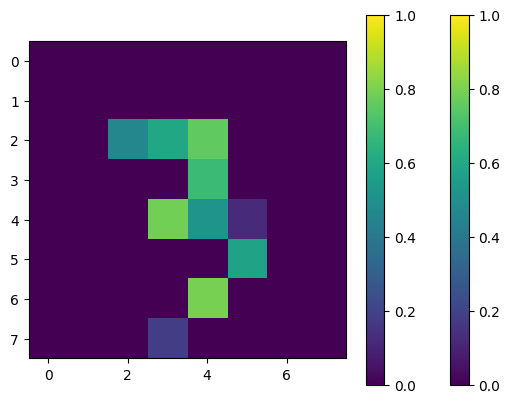

In [13]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

x_train_small = tf.image.resize(x_train, (8,8)).numpy()
x_test_small = tf.image.resize(x_test, (8,8)).numpy()

print(y_train[10])

plt.imshow(x_train_small[10,:,:,0], vmin=0, vmax=1)
plt.colorbar()


In [14]:
#x_train_small = x_train_small[0:800]
#x_test_small = x_test_small[0:100]

#We want output of 1 of -1
y_train = 2.0*y_train - 1.0
y_test = 2.0*y_test - 1.0

#y_train = y_train[0:800]
#y_test = y_test[0:100]

qubits = cirq.GridQubit.rect(1, 6) #grid of qubit


quantum_states_train = [np.ravel(x_train_small[i]) for i in range(len(x_train_small))]
quantum_states_test = [np.ravel(x_test_small[i]) for i in range(len(x_test_small))]

train_circuits_data = [amplitude_encoding(qubits, quantum_states_train[i]) for i in range(len(quantum_states_train))] 
test_circuits_data = [amplitude_encoding(qubits, quantum_states_test[i]) for i in range(len(quantum_states_test))] 




In [15]:
import json

json_circuits = [cirq.to_json(train_circuits_data[i]) for i in range(len(train_circuits_data))]

# Open a file in write mode
with open('amplitude_encoding_train.json', 'w') as f:
    # Use json.dump() to write the list of JSON strings to the file
    json.dump(json_circuits, f)

# Close the file
f.close()

json_circuits = [cirq.to_json(test_circuits_data[i]) for i in range(len(test_circuits_data))]

# Open a file in write mode
with open('amplitude_encoding_test.json', 'w') as f:
    # Use json.dump() to write the list of JSON strings to the file
    json.dump(json_circuits, f)

# Close the file
f.close()

np.savetxt("y_train.txt", y_train)
np.savetxt("y_test.txt", y_test)